Column names in the dataset:
Index(['id', 'html', 'political', 'not_political', 'title', 'Gun_leg',
       'message', 'thumbnail', 'created_at', 'updated_at',
       ...
       'Unnamed: 173', 'Unnamed: 174', 'Unnamed: 175', 'Unnamed: 176',
       'Unnamed: 177', 'Unnamed: 178', 'Unnamed: 179', 'Unnamed: 180',
       'Unnamed: 181', 'Unnamed: 182'],
      dtype='object', length=183)


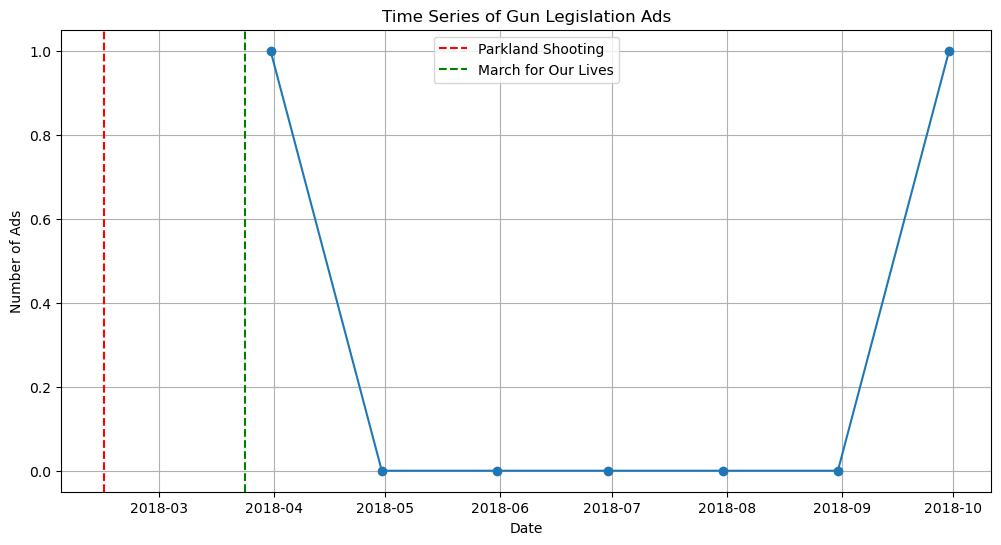

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
file_path = 'areen-prehandcode.csv'  # Replace with the path to your dataset
data = pd.read_csv(file_path)

# Print the column names to verify
print("Column names in the dataset:")
print(data.columns)

# Define the column name containing date information
date_column = 'created_at'  # Change this to the correct column name

# Function to check if a string can be converted to a date
def is_date(string):
    try:
        pd.to_datetime(string)
        return True
    except (ValueError, TypeError):
        return False

# Filter out non-date entries in the date column
data = data[data[date_column].apply(is_date)]

# Convert the valid entries to datetime with timezone UTC
data[date_column] = pd.to_datetime(data[date_column], utc=True)

# Define the dates of interest (March for Our Lives and Parkland shooting)
march_for_our_lives_date = pd.to_datetime('2018-03-24', utc=True)
parkland_shooting_date = pd.to_datetime('2018-02-14', utc=True)

# Filter the dataset to include only messages within 6 months before and after each event
data_filtered = data[(data[date_column] >= parkland_shooting_date - pd.DateOffset(months=6)) &
                     (data[date_column] <= march_for_our_lives_date + pd.DateOffset(months=6))]

# Filter the dataset to include only messages related to gun legislation ads
gun_leg_data = data_filtered[data_filtered['Gun_leg'] == 1]

# Aggregate the data based on the date to create a time series
time_series = gun_leg_data.set_index(date_column).resample('M').size()  # Monthly aggregation

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(time_series.index, time_series.values, marker='o', linestyle='-')
plt.axvline(x=parkland_shooting_date, color='r', linestyle='--', label='Parkland Shooting')
plt.axvline(x=march_for_our_lives_date, color='g', linestyle='--', label='March for Our Lives')
plt.title('Time Series of Gun Legislation Ads')
plt.xlabel('Date')
plt.ylabel('Number of Ads')
plt.legend()
plt.grid(True)
plt.show()


ValueError: x must have 2 complete cycles requires 24 observations. x only has 7 observation(s)


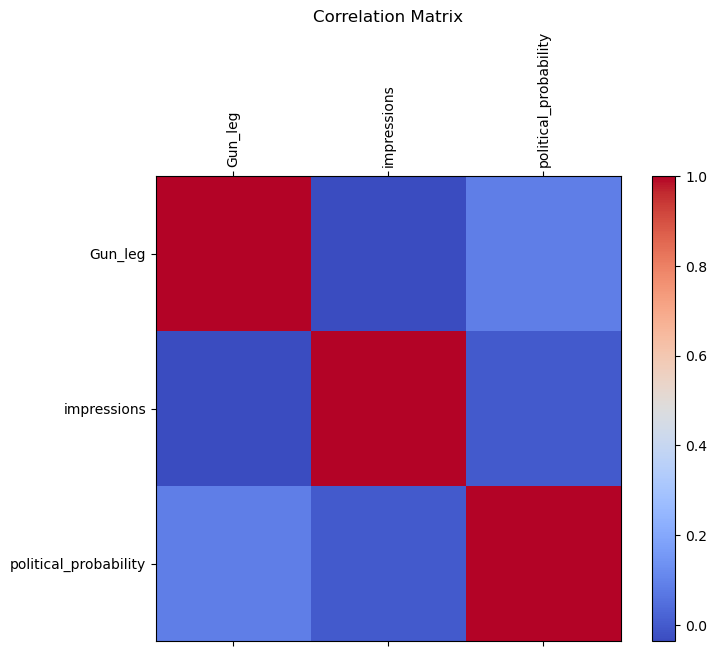

C:\Users\Areen\AppData\Local\Temp\ipykernel_29668\2314337582.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[column_of_interest] = pd.to_numeric(data_filtered[column_of_interest], errors='coerce')


In [6]:
# Decompose the time series into trend, seasonal, and residual components
#NEED MORE DATA BASICALLY - unsure if it works because of it
try:
    decomposition = seasonal_decompose(time_series, model='additive')
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
except ValueError as e:
    print(f"ValueError: {e}")


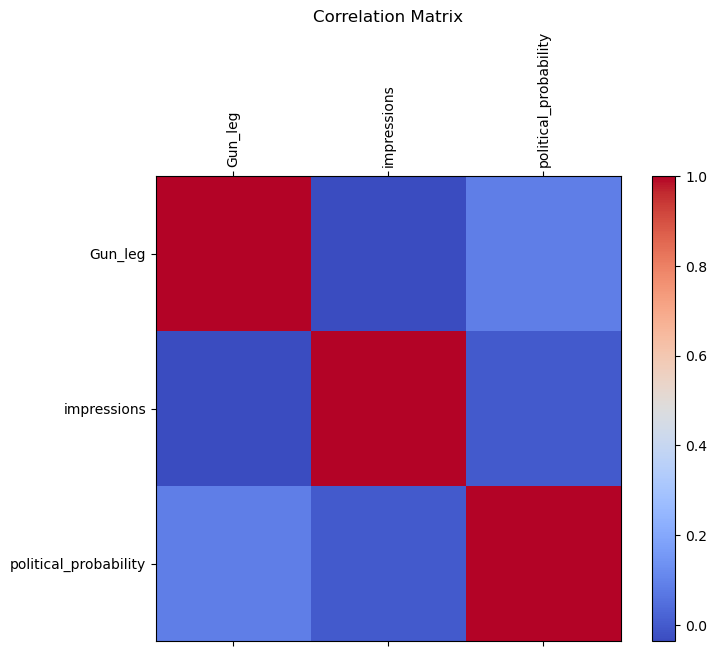

C:\Users\Areen\AppData\Local\Temp\ipykernel_29668\272751374.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[column_of_interest] = pd.to_numeric(data_filtered[column_of_interest], errors='coerce')


In [9]:
# Define the columns of interest for correlation analysis
columns_of_interest = ['Gun_leg', 'impressions', 'political_probability']  # Adjust as needed

# Filter the dataset to include only the relevant columns
relevant_data = data_filtered[columns_of_interest]

# Compute correlation matrix
correlation_matrix = relevant_data.corr()

# Visualize correlation matrix
plt.figure(figsize=(8, 6))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

# Define the column of interest for event detection
column_of_interest = 'impressions'  # Adjust as needed

# Convert the column to numeric, handling errors and converting non-numeric values to NaN
data_filtered[column_of_interest] = pd.to_numeric(data_filtered[column_of_interest], errors='coerce')

# Set threshold for event detection (e.g., percentage change)
threshold = 0.5  # Adjust as needed

# Detect events based on the defined threshold
events = data_filtered[data_filtered[column_of_interest].pct_change().abs() > threshold]

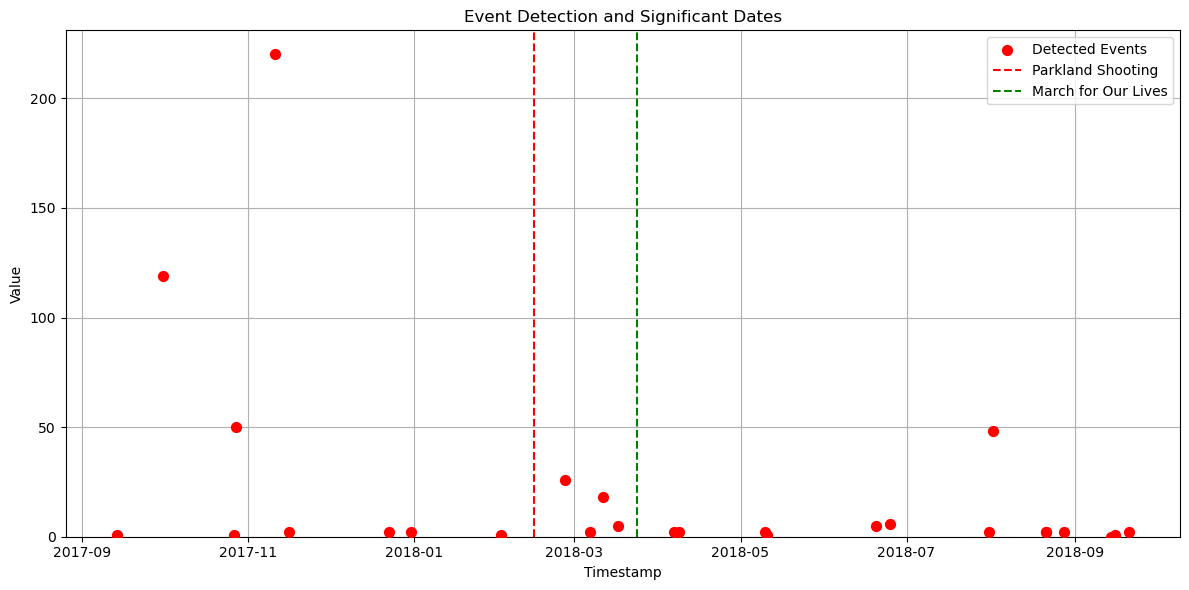

In [8]:
# Plot the detected events and significant dates only
plt.figure(figsize=(12, 6))

# Plot the detected events
plt.scatter(events[date_column], events[column_of_interest], color='red', label='Detected Events', s=50, zorder=5)

# Add vertical lines for significant dates
plt.axvline(x=parkland_shooting_date, color='r', linestyle='--', label='Parkland Shooting')
plt.axvline(x=march_for_our_lives_date, color='g', linestyle='--', label='March for Our Lives')

# Set plot labels and title
plt.title('Event Detection and Significant Dates')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Adjust y-axis limits to avoid overlap
plt.ylim(bottom=0)  # Adjust as needed

plt.tight_layout()
plt.show()